# Bayesian Optimization

https://www.miguelgondu.com/blogposts/2023-07-31/intro-to-bo/

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from skopt import Optimizer, gp_minimize
from tqdm.notebook import trange

from bayesian_optimization import jit_plus_server, plot_example_gpr

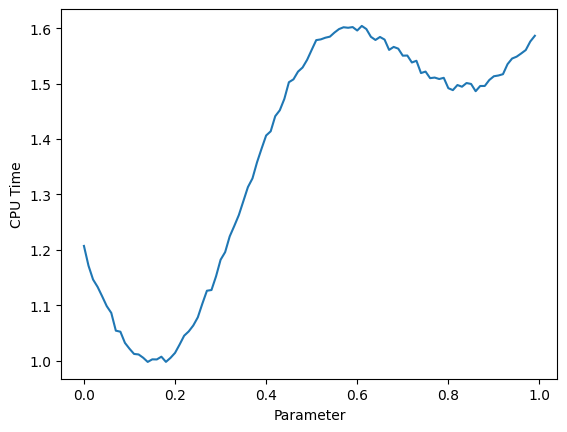

In [2]:
x = np.arange(0, 1, 0.01)
y = [jit_plus_server([i]) for i in x]
plt.plot(x, y)
plt.xlabel("Parameter")
plt.ylabel("CPU Time");

In [3]:
np.random.seed(17)

jit_plus_server([0]), jit_plus_server([0.5])

(1.2025010344211848, 1.5500903091206684)

In [4]:
class GPR1:
    def __init__(self, parameters, measurements):
        self.x = parameters
        self.y = np.array(measurements)
        self.mean_y = self.y.mean()

    def estimate(self, query_parameter):
        return self.mean_y

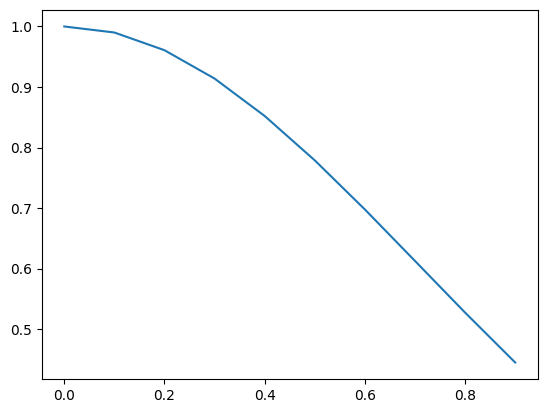

In [5]:
x = np.arange(0, 1, 0.1)
parameter = 0.0
weight = np.exp(-((x - parameter) ** 2))
plt.plot(x, weight);

In [6]:
class GPR2:
    def __init__(self, parameters, measurements, sigma):
        self.x = parameters
        self.y = np.array(measurements)
        self.sigma = sigma

        self.mean_y = self.y.mean()
        self.y -= self.mean_y

    def kernel(self, x1, x2):
        distance_squared = ((x1 - x2) ** 2).sum()
        return np.exp(-distance_squared / (2 * self.sigma**2))

    def estimate(self, query_parameter):
        weights = [self.kernel(x, query_parameter) for x in self.x]
        weights = np.array(weights)
        weights = weights / weights.sum()
        return self.mean_y + weights @ self.y

In [7]:
parameters = np.array([0.5, 0.0])
measurements = np.array([1.52, 1.21])
gpr = GPR2(parameters, measurements, sigma=0.25)
gpr.estimate(0.25), gpr.estimate(0.4)

(1.365, 1.4482426828846955)

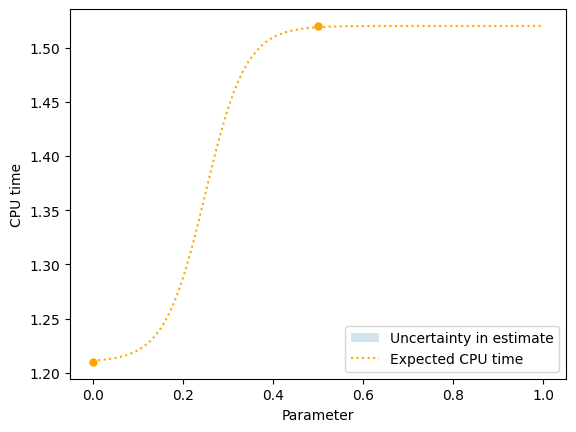

In [8]:
np.random.seed(17)

ax = plt.gca()
plot_example_gpr(GPR2, ax, parameters, measurements, err_bars=True)
plt.xlabel("Parameter")
plt.ylabel("CPU time");

In [9]:
class GPR3:
    def __init__(self, parameters, measurements, sigma):
        self.x = parameters
        self.y = np.array(measurements)
        self.sigma = sigma

        self.mean_y = self.y.mean()
        self.y -= self.mean_y

    def kernel(self, x1, x2):
        distance_squared = ((x1 - x2) ** 2).sum()
        return np.exp(-distance_squared / (2 * self.sigma**2))

    def estimate(self, query_parameter):
        kernels_x_query = np.array([self.kernel(x, query_parameter) for x in self.x])
        kernels_x_x = np.array(
            [[self.kernel(x1, x2) for x1 in self.x] for x2 in self.x]
        )
        weights = kernels_x_query.T @ np.linalg.inv(kernels_x_x)
        return self.mean_y + weights @ self.y

In [10]:
gpr = GPR3(parameters, measurements, sigma=0.15)
gpr.estimate(0.25), gpr.estimate(0.4)

(1.365, 1.4851511395406307)

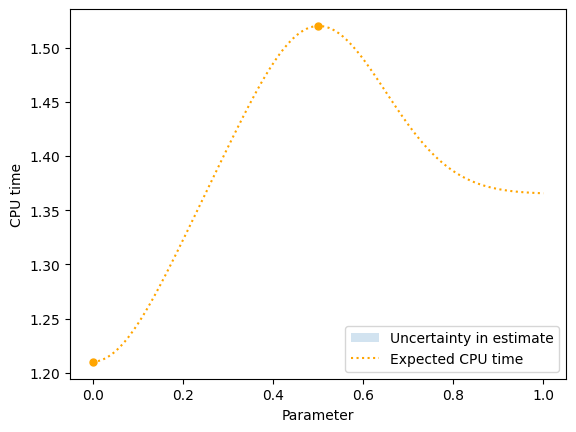

In [11]:
np.random.seed(17)

ax = plt.gca()
plot_example_gpr(GPR3, ax, parameters, measurements, err_bars=True)
plt.xlabel("Parameter")
plt.ylabel("CPU time");

In [12]:
class GPR4:
    def __init__(self, parameters, measurements, sigma):
        self.x = parameters
        self.y = np.array(measurements)
        self.sigma = sigma

        self.mean_y = self.y.mean()
        # Need at least 2 values to compute std dev.
        if len(self.y) > 1:
            self.std_y = self.y.std()
        else:
            self.std_y = 1
        self.y -= self.mean_y

    def kernel(self, x1, x2):
        distance_squared = ((x1 - x2) ** 2).sum()
        return np.exp(-distance_squared / (2 * self.sigma**2))

    def estimate(self, query_parameter):
        kernels_x_query = np.array([self.kernel(x, query_parameter) for x in self.x])
        kernels_x_x = np.array(
            [[self.kernel(x1, x2) for x1 in self.x] for x2 in self.x]
        )
        weights = kernels_x_query.T @ np.linalg.pinv(kernels_x_x)
        expectation = self.mean_y + weights @ self.y
        uncertainty_squared = 1 - weights @ kernels_x_query
        uncertainty = np.sqrt(uncertainty_squared)
        return expectation, self.std_y * uncertainty

In [13]:
gpr = GPR4(parameters, measurements, sigma=0.15)
gpr.estimate(0.25), gpr.estimate(0.4)

((1.365, 0.14508247066963484), (1.4851511395406307, 0.09276343849139895))

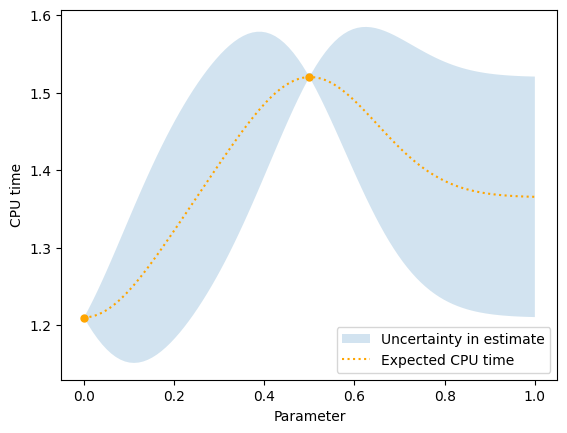

In [14]:
np.random.seed(17)

ax = plt.gca()
plot_example_gpr(GPR4, ax, parameters, measurements, err_bars=True)
plt.xlabel("Parameter")
plt.ylabel("CPU time");

In [15]:
np.random.seed(17)

gpr = GPR4(parameters, measurements, sigma=0.15)
x_hats = np.linspace(0, 1, 100)
y_hats, sigma_y_hats = zip(*[gpr.estimate(x_hat) for x_hat in x_hats])
k = 1
lcb = np.array(y_hats) - k * np.array(sigma_y_hats)
i = np.where(lcb == lcb.min())
x_hats[i]

array([0.11111111])

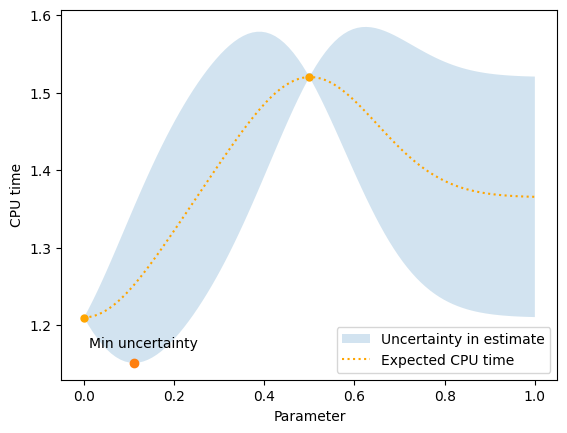

In [16]:
np.random.seed(17)

ax = plt.gca()
plot_example_gpr(GPR4, ax, parameters, measurements, err_bars=True)
plt.xlabel("Parameter")
plt.ylabel("CPU time")
plt.scatter(x_hats[i], lcb.min())
plt.text(x_hats[i] - 0.1, lcb.min() + 0.02, "Min uncertainty");

## Optimizing all seven compiler parameters

In [17]:
def evaluate(gpr, x):
    # Ensure the parameter values are in [0, 1]
    x = np.mod(x, 1)
    y, sigma_y = gpr.estimate(x)
    lcb = y - sigma_y
    return x, lcb


def random_search(gpr, num_parameters, num_iterations=1000):
    step_size = 0.1
    x_current = np.random.normal(size=num_parameters)
    x_current, lcb_current = evaluate(gpr, x_current)
    trace = []
    for _ in range(num_iterations):
        x_test = x_current + step_size * np.random.normal(size=num_parameters)
        x_test, lcb_test = evaluate(gpr, x_test)
        if lcb_test < lcb_current:
            lcb_current = lcb_test
            x_current = x_test
        trace.append(lcb_current)
    return x_current, np.array(trace)

In [18]:
np.random.seed(17)


gpr = GPR4(parameters, measurements, sigma=0.15)
x_opt, trace = random_search(gpr, num_parameters=1)
x_opt

array([0.11096591])

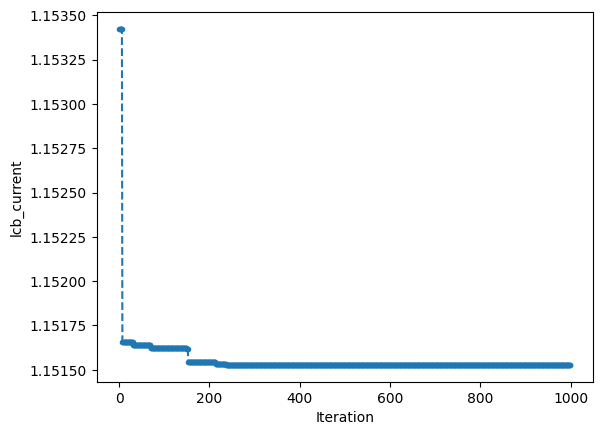

In [19]:
plt.plot(trace, ".--")
plt.xlabel("Iteration")
plt.ylabel("lcb_current");

In [20]:
class BayesianOptimizer:
    def __init__(self, num_parameters):
        self.num_parameters = num_parameters
        self.parameters = []
        self.measurements = []
        self.x0 = np.array([0.5] * num_parameters)

    def ask(self):
        if len(self.measurements) == 0:
            return self.x0
        return self.new_parameter()

    def new_parameter(self):
        gpr = GPR4(self.parameters, self.measurements, sigma=0.15)
        return random_search(gpr, self.num_parameters, num_iterations=500)[0]

    def tell(self, parameter, measurement):
        self.parameters.append(parameter)
        self.measurements.append(measurement)

In [21]:
np.random.seed(7)
bo = BayesianOptimizer(num_parameters=7)
for _ in trange(48):
    parameter = bo.ask()
    cpu_time = jit_plus_server(parameter)
    bo.tell(parameter, cpu_time)

  0%|          | 0/48 [00:00<?, ?it/s]

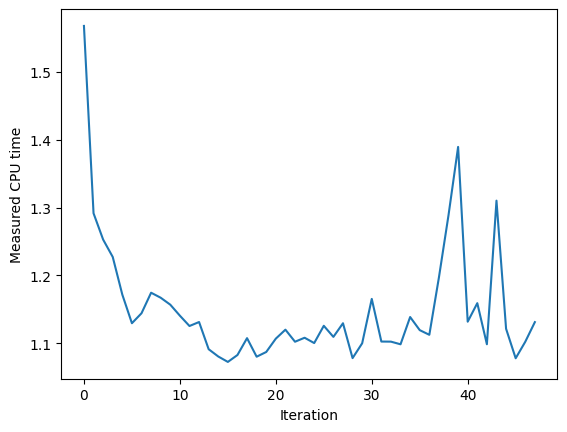

In [22]:
plt.plot(bo.measurements)
plt.xlabel("Iteration")
plt.ylabel("Measured CPU time");

In [8]:
def f(x):
    return jit_plus_server(x)


res = gp_minimize(f, [(0.0, 1.0)] * 7)
res

          fun: 1.0741683509160753
            x: [0.0, 0.1645154997161642, 0.0, 0.14860109169418706, 0.15450440433199167, 0.0, 0.1573533283838304]
    func_vals: [ 1.483e+00  1.299e+00 ...  1.076e+00  1.092e+00]
      x_iters: [[0.9505428900132081, 0.4662570884902242, 0.4536753543417824, 0.8107386699627013, 0.300800419180937, 0.7276852018786215, 0.983343586937705], [0.006457465031792566, 0.31514822385587843, 0.3645925262461109, 0.29411545984823456, 0.7322300364577708, 0.3810796910538483, 0.37571356688086066], [0.20648423501023877, 0.4059568733651626, 0.2800630922140909, 0.14219028758064559, 0.5897616000671844, 0.4457521125885734, 0.24460758432850543], [0.47107340482377413, 0.22846805426656008, 0.338707804192315, 0.6224099686001775, 0.09019509841287689, 0.5382257082818528, 0.3863636539586247], [0.2504480641094953, 0.0688740210179586, 0.5281090361360566, 0.4368148030594404, 0.6118550870708113, 0.3111998916925755, 0.132525109833493], [0.42459254470999563, 0.4532312942585197, 0.62249361127

In [11]:
opt = Optimizer([(0.0, 1.0)] * 7)

for i in range(20):
    suggested = opt.ask()
    y = f(suggested)
    opt.tell(suggested, y)
    print("iteration:", i, suggested, y)

iteration: 0 [0.7680126827075388, 0.2737507758854529, 0.0983303341353611, 0.8091855064246558, 0.34256136996670766, 0.9716276427243538, 0.7285953555342425] 1.3550926517318824
iteration: 1 [0.03699749278437126, 0.588703820278698, 0.6000274190525222, 0.41738366270153626, 0.5114899549954842, 0.6427808176988448, 0.7608842307532359] 1.490286211314082
iteration: 2 [0.10135848571137387, 0.26389232905151355, 0.9091648239636848, 0.6366276734933795, 0.9295026234894134, 0.8692203614896017, 0.8859290501193525] 1.3905625741385157
iteration: 3 [0.29815079135778194, 0.8199988339564829, 0.729417771651919, 0.6984367252097662, 0.8016281898236042, 0.6797256597855701, 0.8636236456492951] 1.479833111288026
iteration: 4 [0.8561659850508803, 0.737965577435155, 0.5063804260525114, 0.1639702842695039, 0.32116367267018514, 0.8596274025556738, 0.7196665504785855] 1.4058023097626622
iteration: 5 [0.3912188154147921, 0.053181461628393115, 0.9474928219749631, 0.5847788246406278, 0.04205328698018907, 0.43194874877806